In [122]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [123]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import scipy as sp
from scipy import signal
import os
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import regionmask

In [124]:
# first load your data

dirn = '/global/scratch/medhap02/ISMData/'
filen = 'TRMM.nc'
datgpcp = xr.open_mfdataset(dirn+filen,combine='by_coords')
# precip units are mm/day:
prgpcp = datgpcp['PRECIP']
prgpcp = prgpcp.rename({
    "LAT": "lat",
    "LON": "lon",
    "TIME":"time"
})

# select years of interest (dataset only goes thru march 2019):
prgpcp = prgpcp.sel(time=slice('1900-01-01','2014-12-31'))

In [125]:
# take summer mean:
def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcp.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean())

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")
print(prgpcpSeas.dims)

# rechunk data for efficiency:
prgpcpSeas.data = prgpcpSeas.data.rechunk(-1)

# eliminate any NaNs:
#prgpcpSeas = prgpcpSeas.ffill('lon').bfill('lon').ffill('lat').bfill('lat')
prgpcpSeas.load()

('year', 'lat', 'lon')


<xarray.DataArray 'PRECIP' (year: 17, lat: 400, lon: 1440)>
array([[[0.475855, 0.491984, ..., 1.347589, 0.994081],
        [0.480782, 0.435137, ..., 0.94396 , 0.720436],
        ...,
        [2.590234, 2.869976, ..., 3.290508, 2.484242],
        [2.255734, 2.399395, ..., 3.09146 , 2.530145]],

       [[0.980457, 0.944089, ..., 1.015843, 0.880472],
        [0.806903, 0.842298, ..., 0.991379, 0.842911],
        ...,
        [1.067266, 1.256919, ..., 1.344008, 1.511637],
        [1.304161, 1.204565, ..., 1.192734, 1.422153]],

       ...,

       [[0.71375 , 0.696177, ..., 0.607847, 0.71496 ],
        [0.812726, 0.785113, ..., 0.662935, 0.714403],
        ...,
        [3.94229 , 3.827016, ..., 3.437015, 3.847718],
        [4.016887, 4.141419, ..., 3.423846, 3.536548]],

       [[0.540935, 0.580315, ..., 0.669129, 0.643161],
        [0.503315, 0.510952, ..., 0.556323, 0.557266],
        ...,
        [1.758137, 1.675637, ..., 2.112734, 1.868081],
        [1.735798, 1.619605, ..., 1.889952, 

In [126]:
latlim1 = -90
latlim2 = 90

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_prfull = Eof(tmppr,weights=coslat2,center=True)
pcs_prfull = solver_prfull.pcs()
eofs_prfull = solver_prfull.eofs()
varfrac_prfull = solver_prfull.varianceFraction()

In [127]:
#(5-35n, 65-95e)
latlim1 = 5
latlim2 = 35
lonlim1 = 65
lonlim2 = 95

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))

# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_pr = Eof(tmppr,weights=coslat2,center=True)
pcs_pr = solver_pr.pcs()
eofs_pr = solver_pr.eofs()
varfrac_pr = solver_pr.varianceFraction()

In [128]:
# take seasonal mean and select latitudes to use in analysis:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(prgpcpSeas)
India_index = regionmask.defined_regions.natural_earth.countries_110.map_keys("India")
precip_India = prgpcpSeas.where(mask == India_index)

# subtract time mean from each data point (EOFs work with anomalies)
precip_India = precip_India - precip_India.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
precip_India.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(precip_India.lat*np.pi/180)
precip_India2, coslat2 = xr.broadcast(precip_India, coslat)

# find the EOFs
India_solver_pr = Eof(precip_India,weights=coslat2,center=True)
India_pcs_pr = India_solver_pr.pcs()
India_eofs_pr = India_solver_pr.eofs()
India_varfrac_pr = India_solver_pr.varianceFraction()

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# plot results

sum of variance in first 4 pr EOFs =  0.4451475175401428
total anomaly variance pr = 659161.2410306144


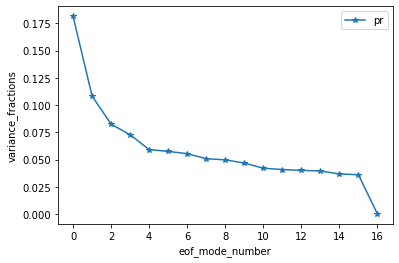

In [129]:
varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_prfull.totalAnomalyVariance())

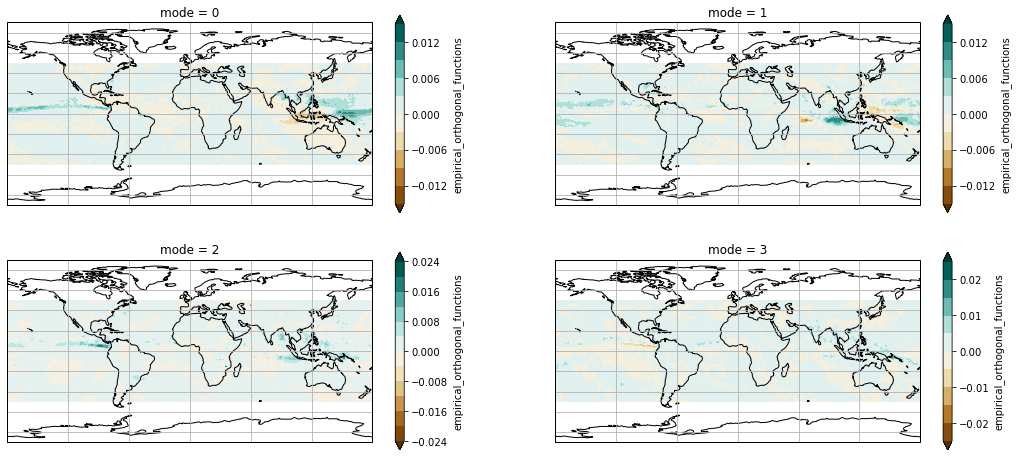

In [130]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_prfull[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

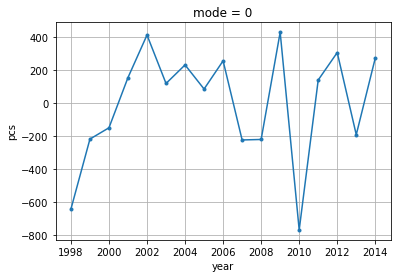

In [131]:
pcs_prfull.sel(mode=0).plot(marker='.')
plt.grid()

sum of variance in first 4 pr EOFs =  0.5513794128060117
total anomaly variance pr = 44954.09028923951


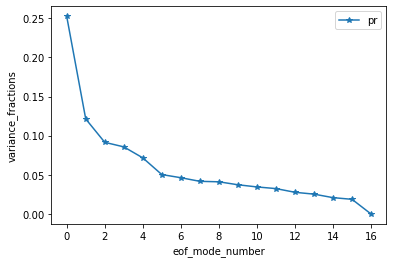

In [132]:
varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr.totalAnomalyVariance())

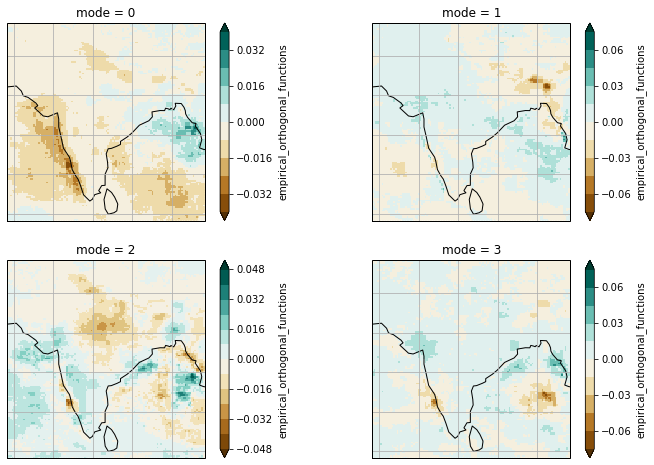

In [133]:
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

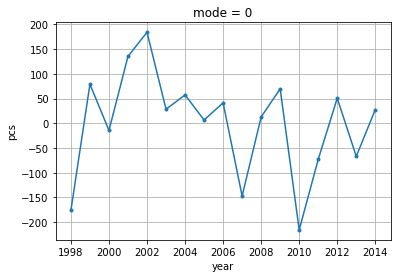

In [134]:
levels=np.linspace(-15, 15, 13)
pcs_pr.sel(mode=0).plot(marker='.')
plt.grid()

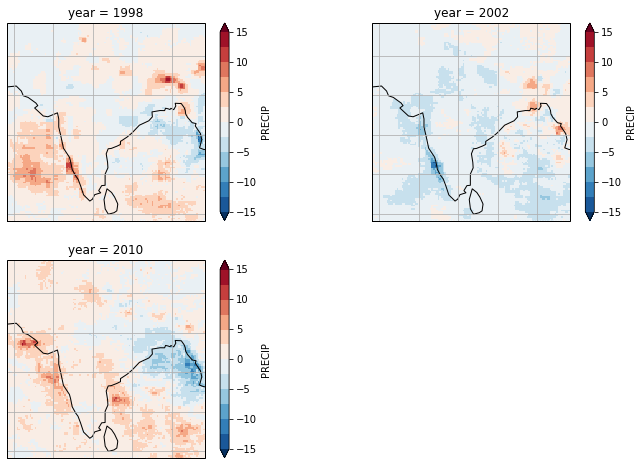

In [135]:
pcs_pr.sel(mode=0)
mode0 = [0, 4, 12]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

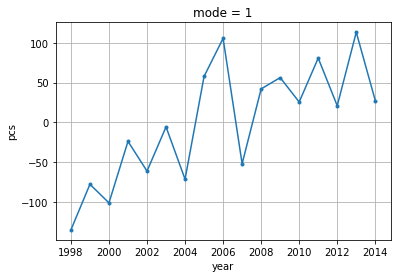

In [136]:
pcs_pr.sel(mode=1).plot(marker='.')
plt.grid()

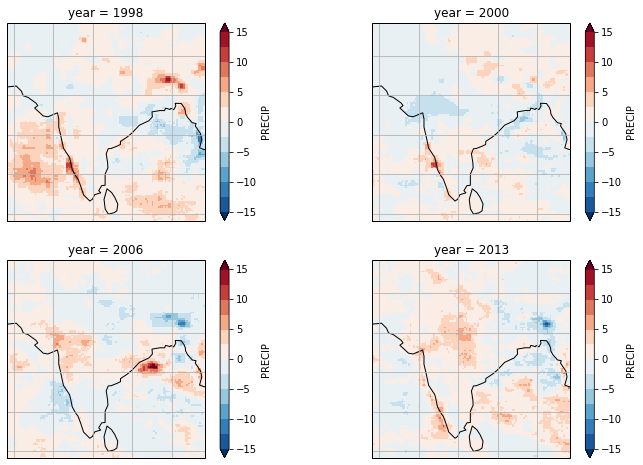

In [137]:
pcs_pr.sel(mode=1)
mode1 = [0, 2, 8, 15]
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode1[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

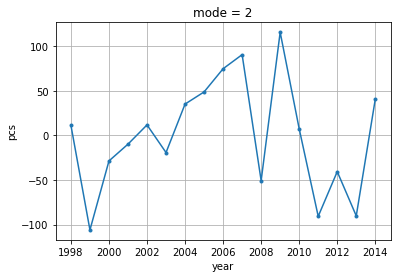

In [138]:
pcs_pr.sel(mode=2).plot(marker='.')
plt.grid()

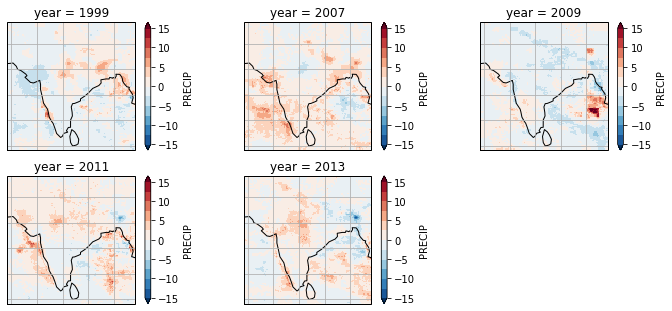

In [139]:
pcs_pr.sel(mode=2)
mode2 = [1, 9, 11, 13, 15]
plt.figure(figsize=(12,8))
for i in np.arange(0,5):
    ax = plt.subplot(3,3,i+1,projection=ccrs.PlateCarree());
    tmppr[mode2[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

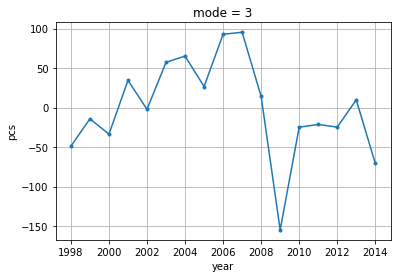

In [140]:
pcs_pr.sel(mode=3).plot(marker='.')
plt.grid()

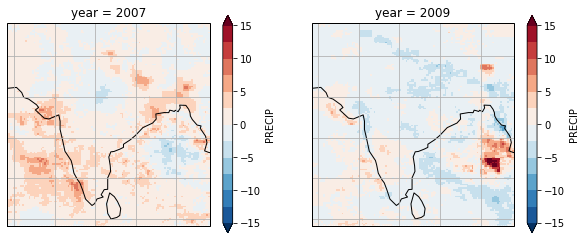

In [158]:
pcs_pr.sel(mode=3)
mode3 = [9, 11]
plt.figure(figsize=(10,4))
for i in np.arange(0,2):
    ax = plt.subplot(1,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode3[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

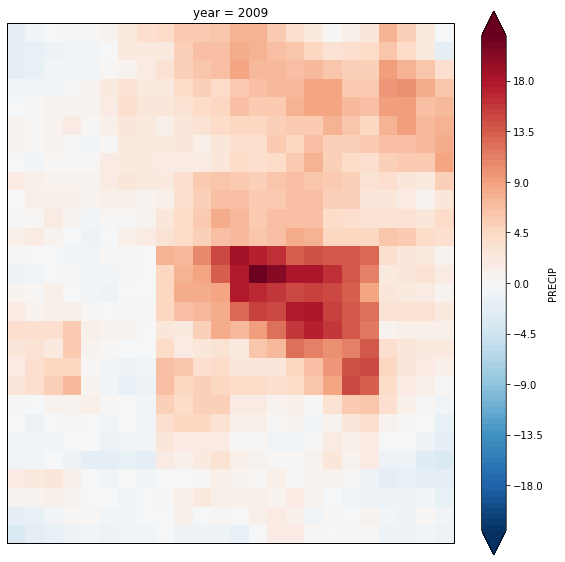

In [142]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
tmppr[11,:,:].plot.pcolormesh(ax=ax,levels=101,extend='both')
ax.coastlines()
ax.set_extent([88,94,11,18],crs=ccrs.PlateCarree())

# correlation with AIRI

In [144]:
dirn = '/global/scratch/medhap02/ISMData/'
filen = 'pALLIN.nc'
airi_dat = xr.open_dataset(dirn+filen, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
precip = airi_dat['precip']

precipfull = precip.sel(time=slice('1998-01-01','2014-12-31'))

In [145]:
def is_summer(month):
    return (month >= 6) & (month <= 9)
precip_subset = precipfull.sel(time=is_summer(precipfull['time.month']))#.groupby('time.year').mean()


precip_subset = precip_subset.groupby('time.year',restore_coord_dims = True).sum("time")
#print(precip_subset.dims)

#print(precip_subset)

precip_jjas = precip_subset - precip_subset.mean(dim='year')

print(precip_jjas)

<xarray.DataArray 'precip' (year: 17)>
array([ -22.870605,   -0.670593,   28.029419,   26.629395, -138.1706  ,
         -4.070618,  -11.870605,  -41.870605,  103.22937 ,   64.82941 ,
         42.52942 , -108.870605,   36.129395,   43.329346,  -64.870605,
        129.92938 ,  -81.370605], dtype=float32)
Coordinates:
  * year     (year) int64 1998 1999 2000 2001 2002 ... 2010 2011 2012 2013 2014


In [146]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [147]:
corr0 = correlation(pcs_pr.sel(mode=0), precip_jjas, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(pcs_pr.sel(mode=3), precip_jjas, dims='year')
print("TRMM (1998 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

TRMM (1998 - 2014)
mode 0:  -0.464382887613102
mode 1:  0.2985956069905615
mode 2:  -0.3050529826731097
mode 3:  0.5505300993972555


# regionmask India

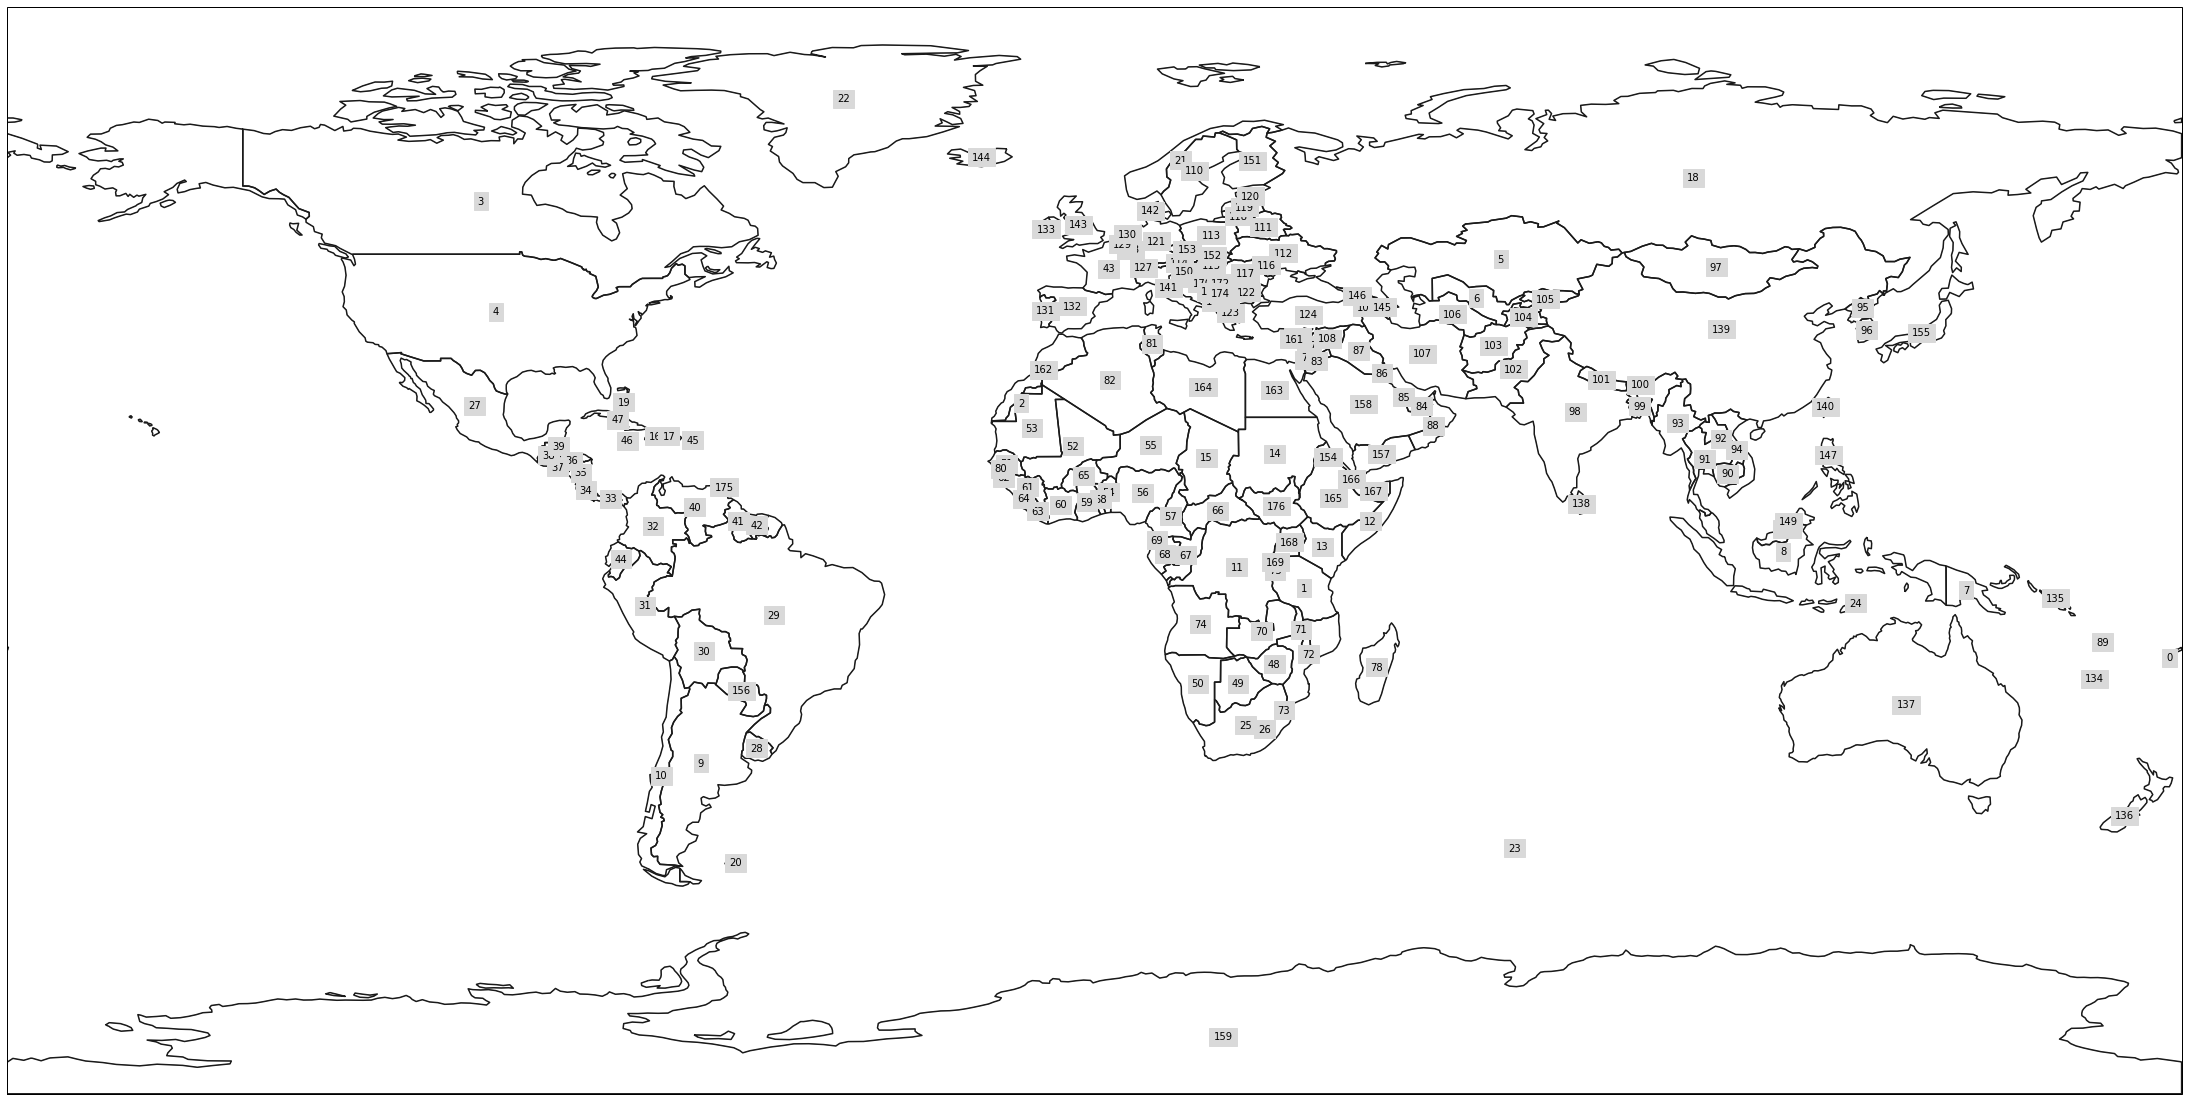

In [148]:
plt.figure(figsize=(40,20))
regionmask.defined_regions.natural_earth.countries_110.plot()

sum of variance in first 4 pr EOFs =  0.6202055641885654
total anomaly variance pr = 12702.177302390486


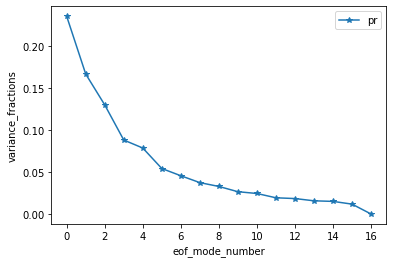

In [149]:
India_varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', India_varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', India_solver_pr.totalAnomalyVariance())

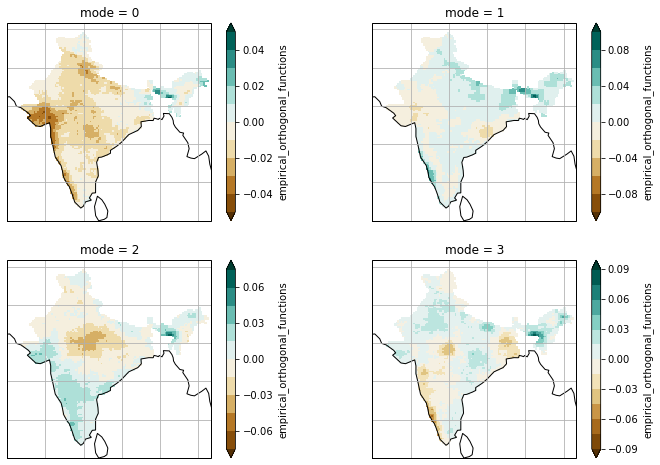

In [150]:
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    India_eofs_pr[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([66,98,6,37],crs=ccrs.PlateCarree())

In [151]:
corr0 = correlation(India_pcs_pr.sel(mode=0), precip_jjas, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(India_pcs_pr.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(India_pcs_pr.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(India_pcs_pr.sel(mode=3), precip_jjas, dims='year')
print("India TRMM (1998 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

India TRMM (1998 - 2014)
mode 0:  -0.7532875363959995
mode 1:  0.04347562980249315
mode 2:  -0.15168075656061128
mode 3:  -0.11913209730893358


# west of bangladesh

In [167]:
#[65,89,8,35]
latlim1 = 8
latlim2 = 35
lonlim1 = 65
lonlim2 = 89

# take seasonal mean and select latitudes to use in analysis:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(prgpcpSeas)
WestofBangladesh_index = regionmask.defined_regions.natural_earth.countries_110.map_keys("India")
precip_WestofBangladesh = prgpcpSeas.where(mask == WestofBangladesh_index)
precip_WestofBangladesh = precip_WestofBangladesh.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))

# subtract time mean from each data point (EOFs work with anomalies)
precip_WestofBangladesh = precip_WestofBangladesh - precip_WestofBangladesh.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
precip_WestofBangladesh.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(precip_WestofBangladesh.lat*np.pi/180)
precip_WestofBangladesh2, coslat2 = xr.broadcast(precip_WestofBangladesh, coslat)

# find the EOFs
solver_pr_WestofBangladesh = Eof(precip_WestofBangladesh,weights=coslat2,center=True)
pcs_pr_WestofBangladesh = solver_pr_WestofBangladesh.pcs()
eofs_pr_WestofBangladesh = solver_pr_WestofBangladesh.eofs()
varfrac_pr_WestofBangladesh = solver_pr_WestofBangladesh.varianceFraction()

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [162]:
#[65,89,8,35]
latlim1 = 8
latlim2 = 35
lonlim1 = 65
lonlim2 = 89

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))

# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_pr_WestofIndia = Eof(tmppr,weights=coslat2,center=True)
pcs_pr_WestofIndia = solver_pr_WestofIndia.pcs()
eofs_pr_WestofIndia = solver_pr_WestofIndia.eofs()
varfrac_pr_WestofIndia = solver_pr_WestofIndia.varianceFraction()

sum of variance in first 4 pr EOFs =  0.6392303096056947
total anomaly variance pr = 10937.332264509614


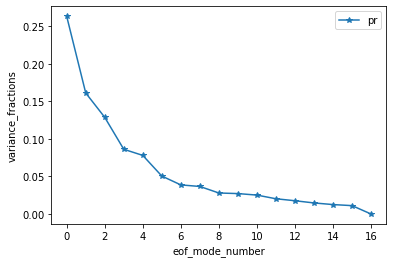

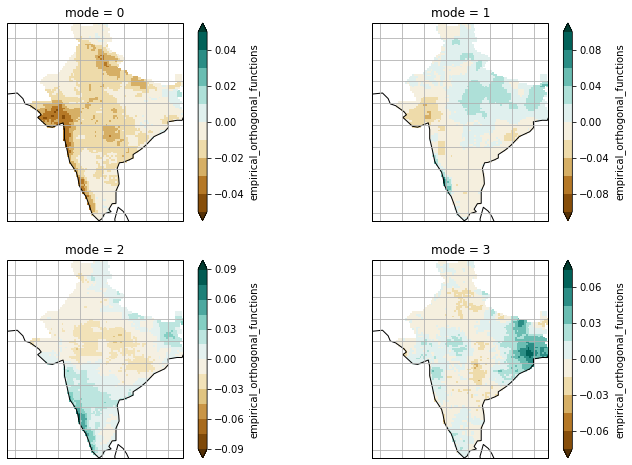

In [168]:
varfrac_pr_WestofBangladesh.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr_WestofBangladesh[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr_WestofBangladesh.totalAnomalyVariance())

plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr_WestofBangladesh[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,89,8,35],crs=ccrs.PlateCarree())

In [170]:
corr0 = correlation(pcs_pr_WestofBangladesh.sel(mode=0), precip_jjas, dims='year')
#corr0.plot.contourf(extend='both')
corr1 = correlation(pcs_pr_WestofBangladesh.sel(mode=1), precip_jjas, dims='year')
corr2 = correlation(pcs_pr_WestofBangladesh.sel(mode=2), precip_jjas, dims='year')
corr3 = correlation(pcs_pr_WestofBangladesh.sel(mode=3), precip_jjas, dims='year')
print("TRMM (1998 - 2014)")
print("mode 0: ", corr0.data)
print("mode 1: ", corr1.data)
print("mode 2: ", corr2.data)
print("mode 3: ", corr3.data)

TRMM (1998 - 2014)
mode 0:  -0.7376759856391903
mode 1:  0.09753127651492288
mode 2:  -0.07619787278695057
mode 3:  0.2660704032724269


In [152]:
 # Copyright (c) 2020 Medha Palavalli.